# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gower
import plotly.express as px
import seaborn as sns
import prince

from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# Objective
The goal is to cluster public companies based on their fundamental metrics, and derive insight from their similarity clustering.

# Reading In Data

The data collected from TD Ameritrade on 12/09/2020 represents the most recent fundamental metrics gathered by the broker up until the date of the API pull request.

In [2]:
stocks_data = pd.read_excel(r'C:\Users\ASUS\Thinkful_Projects\Stock_Clustering\Stocks_df.xlsx')

In [3]:
stocks_data.head()

symbol    high52    low52  dividendAmount  dividendYield  \
0   AAPL  137.9800  53.1525        0.820000           0.66   
1   AAXN  130.4099  50.0510        0.000000           0.00   
2   ACTG    4.4600   1.7500        0.000000           0.00   
3   AAXJ   88.1320  52.9500        1.195746           1.36   
4   ACTC   10.4800   9.7000        0.000000           0.00   

              dividendDate   peRatio  pegRatio   pbRatio   prRatio  ...  \
0  2020-11-06 00:00:00.000  37.88122  3.696739  32.15345   7.66433  ...   
1                            0.00000  0.000000   8.71702  12.45112  ...   
2                           15.75533  0.113612   0.87763   6.74388  ...   
3  2020-06-15 00:00:00.000   0.00000  0.000000   0.00000   0.00000  ...   
4                            0.00000  0.000000   0.00000   0.00000  ...   

   bookValuePerShare  shortIntToFloat  shortIntDayToCover  divGrowthRate3Year  \
0            0.00000                0                   0                   0   
1           30.25857                0                   0                   0   
2            0.00000                0                   0                   0   
3            0.00000                0                   0                   0   
4            0.00000                0                   0                   0   

   dividendPayAmount          dividendPayDate     beta  vol1DayAvg  \
0           0.205000  2020-11-12 00:00:00.000  1.27192    99554530   
1           0.000000                           0.62754      357000   
2           0.000000                           0.79800      275750   
3           0.263149  2020-06-19 00:00:00.000  0.87806      829820   
4           0.000000                           1.00605           0   

   vol10DayAvg  vol3MonthAvg  
0     99554532    2807932720  
1       356998      11909040  
2       275750       4180640  
3      1181178      26253450  
4       168284             0  

[5 rows x 46 columns]

In [4]:
labels = pd.read_csv(r'C:\Users\ASUS\Thinkful_Projects\Stock_Clustering\LabelsList.csv').drop(columns=['MarketCap', 'IPOyear', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])
labels

symbol                                    Name         Sector  \
0     VCVCU    10X Capital Venture Acquisition Corp        Finance   
1       TXG                      10x Genomics, Inc.  Capital Goods   
2        YI                               111, Inc.    Health Care   
3       PIH  1347 Property Insurance Holdings, Inc.        Finance   
4     PIHPP  1347 Property Insurance Holdings, Inc.        Finance   
...     ...                                     ...            ...   
7487   CNET        ZW Data Action Technologies Inc.     Technology   
7488   ZYME                          Zymeworks Inc.    Health Care   
7489   ZYNE           Zynerba Pharmaceuticals, Inc.    Health Care   
7490   ZYXI                             Zynex, Inc.    Health Care   
7491   ZNGA                              Zynga Inc.     Technology   

                                               Industry  
0                                     Business Services  
1      Biotechnology: Laboratory Analytical Instruments  
2                              Medical/Nursing Services  
3                            Property-Casualty Insurers  
4                            Property-Casualty Insurers  
...                                                 ...  
7487    Computer Software: Programming, Data Processing  
7488                              Major Pharmaceuticals  
7489                              Major Pharmaceuticals  
7490  Biotechnology: Electromedical & Electrotherape...  
7491                                       EDP Services  

[7492 rows x 4 columns]

## Merging in Sector and Industry labels to DataFrame

In [5]:
df = pd.merge(stocks_data, labels, on='symbol', how='left')
df

symbol    high52    low52  dividendAmount  dividendYield  \
0      AAPL  137.9800  53.1525        0.820000           0.66   
1      AAXN  130.4099  50.0510        0.000000           0.00   
2      ACTG    4.4600   1.7500        0.000000           0.00   
3      AAXJ   88.1320  52.9500        1.195746           1.36   
4      ACTC   10.4800   9.7000        0.000000           0.00   
...     ...       ...      ...             ...            ...   
6815     ZS  189.6450  35.0000        0.000000           0.00   
6816   ZIOP    5.6050   1.7950        0.000000           0.00   
6817   ZKIN    3.0500   0.6510        0.000000           0.00   
6818   ZYME   56.7300  20.3300        0.000000           0.00   
6819   ZEAL   44.6000  22.0000        0.000000           0.00   

                 dividendDate   peRatio  pegRatio   pbRatio   prRatio  ...  \
0     2020-11-06 00:00:00.000  37.88122  3.696739  32.15345   7.66433  ...   
1                               0.00000  0.000000   8.71702  12.45112  ...   
2                              15.75533  0.113612   0.87763   6.74388  ...   
3     2020-06-15 00:00:00.000   0.00000  0.000000   0.00000   0.00000  ...   
4                               0.00000  0.000000   0.00000   0.00000  ...   
...                       ...       ...       ...       ...       ...  ...   
6815                            0.00000  0.000000  48.56145  49.75946  ...   
6816                            0.00000  0.000000   4.03450   0.00000  ...   
6817                            7.49734  0.000000   0.74106   0.44982  ...   
6818                            0.00000  0.000000   5.77351  99.32008  ...   
6819                            0.00000  0.000000   0.00000   0.00000  ...   

      divGrowthRate3Year  dividendPayAmount          dividendPayDate     beta  \
0                      0           0.205000  2020-11-12 00:00:00.000  1.27192   
1                      0           0.000000                           0.62754   
2                      0           0.000000                           0.79800   
3                      0           0.263149  2020-06-19 00:00:00.000  0.87806   
4                      0           0.000000                           1.00605   
...                  ...                ...                      ...      ...   
6815                   0           0.000000                           0.00000   
6816                   0           0.000000                           2.26312   
6817                   0           0.000000                           0.00000   
6818                   0           0.000000                           1.02518   
6819                   0           0.000000                           0.00000   

      vol1DayAvg  vol10DayAvg  vol3MonthAvg  \
0       99554530     99554532    2807932720   
1         357000       356998      11909040   
2         275750       275750       4180640   
3         829820      1181178      26253450   
4              0       168284             0   
...          ...          ...           ...   
6815     3687800      3687797      49779970   
6816     1559380      1559382      32245160   
6817     3901420      3901422      14955080   
6818      502630       502629       9884780   
6819           0         3595             0   

                                                   Name         Sector  \
0                                            Apple Inc.     Technology   
1                                 Axon Enterprise, Inc.  Capital Goods   
2                           Acacia Research Corporation  Miscellaneous   
3     iShares MSCI All Country Asia ex Japan Index Fund            NaN   
4                       ArcLight Clean Transition Corp.        Finance   
...                                                 ...            ...   
6815                                      Zscaler, Inc.     Technology   
6816                              ZIOPHARM Oncology Inc    Health Care   
6817                    ZK International Group Co., Ltd  Capital Goods   
6818     

In [6]:
df.columns

Index(['symbol', 'high52', 'low52', 'dividendAmount', 'dividendYield',
       'dividendDate', 'peRatio', 'pegRatio', 'pbRatio', 'prRatio', 'pcfRatio',
       'grossMarginTTM', 'grossMarginMRQ', 'netProfitMarginTTM',
       'netProfitMarginMRQ', 'operatingMarginTTM', 'operatingMarginMRQ',
       'returnOnEquity', 'returnOnAssets', 'returnOnInvestment', 'quickRatio',
       'currentRatio', 'interestCoverage', 'totalDebtToCapital',
       'ltDebtToEquity', 'totalDebtToEquity', 'epsTTM', 'epsChangePercentTTM',
       'epsChangeYear', 'epsChange', 'revChangeYear', 'revChangeTTM',
       'revChangeIn', 'sharesOutstanding', 'marketCapFloat', 'marketCap',
       'bookValuePerShare', 'shortIntToFloat', 'shortIntDayToCover',
       'divGrowthRate3Year', 'dividendPayAmount', 'dividendPayDate', 'beta',
       'vol1DayAvg', 'vol10DayAvg', 'vol3MonthAvg', 'Name', 'Sector',
       'Industry'],
      dtype='object')

# Data Cleaning

## Checking for nulls and duplicates

In [7]:
print("-----------Information-----------")
print(df.info())
print("----------Duplicates in Data----------")
print('Number of duplicates:', len(df[df.duplicated()]))

-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6820 entries, 0 to 6819
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   symbol               6820 non-null   object 
 1   high52               6820 non-null   float64
 2   low52                6820 non-null   float64
 3   dividendAmount       6820 non-null   float64
 4   dividendYield        6820 non-null   float64
 5   dividendDate         6820 non-null   object 
 6   peRatio              6820 non-null   float64
 7   pegRatio             6820 non-null   float64
 8   pbRatio              6820 non-null   float64
 9   prRatio              6820 non-null   float64
 10  pcfRatio             6820 non-null   float64
 11  grossMarginTTM       6820 non-null   float64
 12  grossMarginMRQ       6820 non-null   float64
 13  netProfitMarginTTM   6820 non-null   float64
 14  netProfitMarginMRQ   6820 non-null   float64
 15  oper

Anything presenting with null values for sector AND industry are an ETF or index fund, and thus won't belong in our dataset.

In [8]:
# Drop rows with null values
df_2 = df.dropna(axis=0)
print(df_2.shape)

(5384, 49)


In [9]:
# Drop duplicated rows (by default first copy remains)
df_3 = df_2.drop_duplicates(keep='first')
print(df_3.shape)

(5371, 49)


In [10]:
# Confirm duplicates were removed
len(df_3[df_3.duplicated()])

0

In [11]:
df_3.describe().round(3)

high52     low52  dividendAmount  dividendYield    peRatio  pegRatio  \
count  5371.000  5371.000        5371.000       5371.000   5371.000  5371.000   
mean     54.916    22.742           0.465          1.193     44.253     1.259   
std     141.478    61.384           1.497          2.586    604.273    25.211   
min       0.150     0.000           0.000          0.000      0.000     0.000   
25%      10.800     3.000           0.000          0.000      0.000     0.000   
50%      25.090     9.550           0.000          0.000      0.000     0.000   
75%      53.450    22.010           0.480          1.550     19.496     0.000   
max    4530.000  2043.010          80.000         68.730  36428.570  1553.820   

          pbRatio     prRatio   pcfRatio  grossMarginTTM  ...    marketCap  \
count    5371.000    5371.000   5371.000        5371.000  ...     5371.000   
mean      485.256      94.520     24.129          27.622  ...     9948.803   
std     10458.178    2626.216    294.992          29.386  ...    58154.339   
min         0.000       0.000      0.000           0.000  ...        0.000   
25%         0.719       0.191      0.000           0.000  ...      113.388   
50%         1.660       1.432      0.000          20.456  ...      680.261   
75%         4.219       4.255     14.336          49.829  ...     3955.586   
max    428712.900  163464.100  16770.260         125.860  ...  2103973.000   

       bookValuePerShare  shortIntToFloat  shortIntDayToCover  \
count           5371.000           5371.0              5371.0   
mean               5.948              0.0                 0.0   
std               15.080              0.0                 0.0   
min                0.000              0.0                 0.0   
25%                0.000              0.0                 0.0   
50%                0.000              0.0                 0.0   
75%                6.728              0.0                 0.0   
max              288.910              0.0                 0.0   

       divGrowthRate3Year  dividendPayAmount      beta    vol1DayAvg  \
count              5371.0           5371.000  5371.000  5.371000e+03   
mean                  0.0              0.168     0.953  1.793822e+06   
std                   0.0              0.779     0.902  1.222596e+07   
min                   0.0              0.000     0.000  0.000000e+00   
25%                   0.0              0.000     0.000  5.223000e+04   
50%                   0.0              0.000     0.913  3.005700e+05   
75%                   0.0              0.160     1.495  1.081600e+06   
max                   0.0             29.100     7.594  7.563451e+08   

        vol10DayAvg  vol3MonthAvg  
count  5.371000e+03  5.371000e+03  
mean   1.880732e+06  3.051345e+07  
std    1.231888e+07  1.199694e+08  
min    0.000000e+00  0.000000e+00  
25%    7.286200e+04  8.478350e+05  
50%    3.200790e+05  6.216090e+06  
75%    1.133000e+06  2.248886e+07  
max    7.563451e+08  3.895036e+09  

[8 rows x 43 columns]

The columns: shortIntToFloat, shortIntDayToCover, divGrowthRate3Year do not present anything useful, and as such, can be dropped. While the Divend date columns won't be of any interest for the purposes of clustering the companies.

In [12]:
df_4 = df_3.drop(columns=['shortIntToFloat', 'shortIntDayToCover', 'divGrowthRate3Year', 'dividendDate', 'dividendPayDate'])
print(df_4.shape)

(5371, 44)


# Feature Selection

We are left with 40 numeric variables, meaning we will of course need to reduce our dimensions so that the clustering models can be fitted and executed efficiently. Leaving all the data intact, risks subjecting our clustering models to a lot o potential noise. So we'll start with some manual feature selection based on creating risk vs return profiles for our clusters.

The goal is to cluster companies by their overall performance, to create a strata of low-to-high performers. For such an analysis, we'll dial in on some of the most relevant metrics. (https://www.nasdaq.com/articles/3-most-critical-fundamental-metrics-stock-investors-2017-08-24)

**Returns**
<br>
<br>
ROE = Net Income / Shareholder Equity
>where:
>>Shareholder Equity = Assets - Liabilities
<br> 

ROI = (Current Value of Investment − Cost of Investment) / Cost of Investment

**Risk Measures** 
<br>
<br>
Beta = Measure of volatility or systemic risk compared to the market as a whole. "A beta greater than 1.0 suggests that the stock is more volatile than the broader market, and a beta less than 1.0 indicates a stock with lower volatility" (https://www.investopedia.com/investing/beta-know-risk/)
<br>
Beta coefficient(β) = Covariance(Re,Rm) / Variance(Rm)
>where:
>>Re = the return on an individual stock
>>Rm = the return on the overall market
>>Covariance = how changes in a stock’s returns are related to changes in the market’s returns
>>Variance = how far the market’s data points spread out from their average value

In [13]:
df_5 = df_4.set_index('symbol')
df_5

high52    low52  dividendAmount  dividendYield   peRatio  pegRatio  \
symbol                                                                         
AAPL    137.9800  53.1525            0.82           0.66  37.88122  3.696739   
AAXN    130.4099  50.0510            0.00           0.00   0.00000  0.000000   
ACTG      4.4600   1.7500            0.00           0.00  15.75533  0.113612   
ACTC     10.4800   9.7000            0.00           0.00   0.00000  0.000000   
ADES     12.6300   3.5193            0.00           0.00   0.00000  0.000000   
...          ...      ...             ...            ...       ...       ...   
ZS      189.6450  35.0000            0.00           0.00   0.00000  0.000000   
ZIOP      5.6050   1.7950            0.00           0.00   0.00000  0.000000   
ZKIN      3.0500   0.6510            0.00           0.00   7.49734  0.000000   
ZYME     56.7300  20.3300            0.00           0.00   0.00000  0.000000   
ZEAL     44.6000  22.0000            0.00           0.00   0.00000  0.000000   

         pbRatio   prRatio   pcfRatio  grossMarginTTM  ...     marketCap  \
symbol                                                 ...                 
AAPL    32.15345   7.66433   30.72974        38.23325  ...  2.103973e+06   
AAXN     8.71702  12.45112    0.00000        58.66552  ...  7.803292e+03   
ACTG     0.87763   6.74388    6.25432        73.03254  ...  1.759276e+02   
ACTC     0.00000   0.00000    0.00000         0.00000  ...  2.397238e+02   
ADES     1.18302   1.68378    0.00000        24.02808  ...  9.978763e+01   
...          ...       ...        ...             ...  ...           ...   
ZS      48.56145  49.75946    0.00000        77.53245  ...  2.389733e+04   
ZIOP     4.03450   0.00000    0.00000         0.00000  ...  5.850146e+02   
ZKIN     0.74106   0.44982  122.42660        14.85500  ...  3.261933e+01   
ZYME     5.77351  99.32008    0.00000         0.00000  ...  2.497701e+03   
ZEAL     0.00000   0.00000    0.00000         0.00000  ...  0.000000e+00   

        bookValuePerShare  dividendPayAmount     beta  vol1DayAvg  \
symbol                                                              
AAPL              0.00000              0.205  1.27192    99554530   
AAXN             30.25857              0.000  0.62754      357000   
ACTG              0.00000              0.000  0.79800      275750   
ACTC              0.00000              0.000  1.00605           0   
ADES              0.00000              0.250  0.92656      101490   
...                   ...                ...      ...         ...   
ZS               46.96557              0.000  0.00000     3687800   
ZIOP             10.03436              0.000  2.26312     1559380   
ZKIN              0.00000              0.000  0.00000     3901420   
ZYME             30.45710              0.000  1.02518      502630   
ZEAL              0.00000              0.000  0.00000           0   

        vol10DayAvg  vol3MonthAvg                                Name  \
symbol                                                                  
AAPL       99554532    2807932720                          Apple Inc.   
AAXN         356998      11909040               Axon Enterprise, Inc.   
ACTG         275750       4180640         Acacia Research Corporation   
ACTC         168284             0     ArcLight Clean Transition Corp.   
ADES         101489       8207410  Advanced Emissions Solutions, Inc.   
...             ...           ...                                 ...   
ZS          3687797      49779970                       Zscaler, Inc.   
ZIOP        1559382      32245160               ZIOPHARM Oncology Inc   
ZKIN        3901422      14955080     ZK International Group Co., Ltd   
ZYME         502629       9884780                      Zymeworks Inc.   
ZEAL           3595             0                  Zealand Pharma A/S   

                  Sector                  Industry  
symbol                                              
AAPL          Technology  

> We will focusing on features which will most inform a risk and return profile for our stocks.

In [14]:
df_6 = df_5[['Name', 'Sector', 'Industry', 'returnOnEquity', 'returnOnInvestment', 'beta']]

# Removing 0 values from our dataset
df_7 = df_6.loc[
    (df_6.returnOnEquity != 0) & 
    (df_6.returnOnInvestment != 0) &
    (df_6.beta != 0)
]
df_7

Name             Sector  \
symbol                                                      
AAPL                        Apple Inc.         Technology   
ACTG       Acacia Research Corporation      Miscellaneous   
ACCO           Acco Brands Corporation  Consumer Durables   
AB      AllianceBernstein Holding L.P.            Finance   
AC      Associated Capital Group, Inc.            Finance   
...                                ...                ...   
XEL                   Xcel Energy Inc.   Public Utilities   
ZUMZ                       Zumiez Inc.  Consumer Services   
ZTO          ZTO Express (Cayman) Inc.     Transportation   
ZTS                        Zoetis Inc.        Health Care   
ZYXI                       Zynex, Inc.        Health Care   

                                                 Industry  returnOnEquity  \
symbol                                                                      
AAPL                               Computer Manufacturing        73.68556   
ACTG                               Multi-Sector Companies        13.49569   
ACCO                                           Publishing        10.14677   
AB                                    Investment Managers        18.06116   
AC                     Investment Bankers/Brokers/Service         6.80088   
...                                                   ...             ...   
XEL                                      Power Generation        10.97407   
ZUMZ                       Clothing/Shoe/Accessory Stores        15.40218   
ZTO                     Trucking Freight/Courier Services        12.65620   
ZTS                                 Major Pharmaceuticals        52.96178   
ZYXI    Biotechnology: Electromedical & Electrotherape...        28.91287   

        returnOnInvestment     beta  
symbol                               
AAPL              25.44284  1.27192  
ACTG              14.68407  0.79800  
ACCO               3.38702  2.28385  
AB                18.03733  1.53192  
AC                 2.43643  1.33387  
...                    ...      ...  
XEL                3.12480  0.23673  
ZUMZ               9.66365  1.66478  
ZTO               12.50511  0.27249  
ZTS               15.43175  0.67529  
ZYXI              26.22321  1.08190  

[1585 rows x 6 columns]

# Exploratory Data Analysis

Let's examine what kind of relationship we have between our two categorical features, Sector and Industry.

In [15]:
fig = px.sunburst(df_7, path=['Sector', 'Industry'], width=1000, height=1000)
fig.show()

It is good to take note of just how many 'Industries' can make up a singular 'Sector'. Making the 'Sector' feature more useful for future analysis. 

In [16]:
print(df_7.Sector.nunique())
print(df_7.Industry.nunique())

12
124


## Visualizing Data

First, we remove any observations whose 'Industry' contains 'Trusts' or 'ETF' as we want our analysis to focus on the more traditional business model type of company. 
<br>
<br>
Lastly, we want to know if our dataset contains any outlier observations for the remaining metrics and confirm just how extreme they might be, in comparison to the rest of the datapoints. 

In [17]:
df_8 = df_7.loc[~df_7.Industry.str.contains('Trusts', 'ETF')]
summ_df = df_8.describe()
summ_df.loc['+3_std'] = summ_df.loc['mean'] + (summ_df.loc['std'] * 3)
summ_df.round(3)

returnOnEquity  returnOnInvestment      beta
count         1475.000            1475.000  1475.000
mean            37.550              14.426     1.163
std            236.921             101.502     0.561
min              0.019               0.018     0.004
25%              6.853               3.429     0.794
50%             12.180               6.542     1.101
75%             20.659              11.660     1.475
max           5514.349            3181.230     5.209
+3_std         748.314             318.933     2.847

Based on the statistical comparison of our datapoints max values to our three standard deviations for the whole of the dataset, there are definitely at least some outliers. Let's see how those outliers relate to the larger data set and what they might have in common with each other (by extracting the largest row values for each feature column).

In [18]:
fig = px.box(df_8, y=["returnOnEquity", "returnOnInvestment"])
fig.show()
display(df_8.nlargest(10, 'returnOnEquity'))
display(df_8.nlargest(10, 'returnOnInvestment'))
fig2 = px.box(df_8, y='beta')
fig2.show()
display(df_8.nlargest(10, 'beta'))

Name                 Sector  \
symbol                                                             
HD                 Home Depot, Inc. (The)      Consumer Services   
BPT          BP Prudhoe Bay Royalty Trust                 Energy   
PBT           Permian Basin Royalty Trust                 Energy   
WU            Western Union Company (The)          Miscellaneous   
KMB            Kimberly-Clark Corporation      Consumer Durables   
NRG                      NRG Energy, Inc.       Public Utilities   
NRT     North European Oil Royality Trust                 Energy   
CL              Colgate-Palmolive Company  Consumer Non-Durables   
WAT                    Waters Corporation          Capital Goods   
SBR                  Sabine Royalty Trust                 Energy   

                                                Industry  returnOnEquity  \
symbol                                                                     
HD                            RETAIL: Building Materials       5514.3490   
BPT                             Integrated oil Companies       3420.1790   
PBT                                 Oil & Gas Production       3403.2830   
WU                                     Business Services       2964.5570   
KMB                                 Containers/Packaging       2432.9900   
NRG                          Electric Utilities: Central       2283.1960   
NRT                                 Oil & Gas Production       1812.5950   
CL                               Package Goods/Cosmetics       1635.8660   
WAT     Biotechnology: Laboratory Analytical Instruments       1363.4630   
SBR                                 Oil & Gas Production        848.6165   

        returnOnInvestment     beta  
symbol                               
HD                33.63494  1.04085  
BPT             3181.23000  0.45716  
PBT              943.86180  1.11673  
WU                10.28893  0.98279  
KMB               24.93273  0.52285  
NRG               48.25700  0.97260  
NRT             1812.59500  1.28634  
CL                27.32240  0.58392  
WAT               25.70273  0.86696  
SBR              848.61650  0.63232

Name             Sector  \
symbol                                                         
BPT          BP Prudhoe Bay Royalty Trust             Energy   
NRT     North European Oil Royality Trust             Energy   
PBT           Permian Basin Royalty Trust             Energy   
SBR                  Sabine Royalty Trust             Energy   
XBIT                        XBiotech Inc.        Health Care   
VHC                  VirnetX Holding Corp      Miscellaneous   
PJT                     PJT Partners Inc.            Finance   
LITB      LightInTheBox Holding Co., Ltd.  Consumer Services   
MSB                          Mesabi Trust   Basic Industries   
SJT          San Juan Basin Royalty Trust             Energy   

                              Industry  returnOnEquity  returnOnInvestment  \
symbol                                                                       
BPT           Integrated oil Companies      3420.17900          3181.23000   
NRT               Oil & Gas Production      1812.59500          1812.59500   
PBT               Oil & Gas Production      3403.28300           943.86180   
SBR               Oil & Gas Production       848.61650           848.61650   
XBIT             Major Pharmaceuticals       329.68610           328.84070   
VHC             Multi-Sector Companies       239.76410           239.76010   
PJT                Investment Managers       109.91230           149.22990   
LITB    Catalog/Specialty Distribution       193.84920           125.53680   
MSB                    Precious Metals       117.20660           117.20660   
SJT               Oil & Gas Production        98.21023            88.47697   

           beta  
symbol           
BPT     0.45716  
NRT     1.28634  
PBT     1.11673  
SBR     0.63232  
XBIT    1.66164  
VHC     0.41029  
PJT     0.88898  
LITB    0.74687  
MSB     1.04506  
SJT     0.57479

Name             Sector  \
symbol                                                          
QEP                    QEP Resources, Inc.             Energy   
OSTK                   Overstock.com, Inc.  Consumer Services   
WES         Western Midstream Partners, LP   Public Utilities   
HLX     Helix Energy Solutions Group, Inc.             Energy   
CWH           Camping World Holdings, Inc.  Consumer Durables   
NBLX           Noble Midstream Partners LP             Energy   
EXPI              eXp World Holdings, Inc.            Finance   
GRWG                  GrowGeneration Corp.  Consumer Services   
VCEL                   Vericel Corporation        Health Care   
BOOT              Boot Barn Holdings, Inc.  Consumer Services   

                                                 Industry  returnOnEquity  \
symbol                                                                      
QEP                                  Oil & Gas Production         0.84043   
OSTK                       Catalog/Specialty Distribution         6.03268   
WES                              Natural Gas Distribution        18.43049   
HLX                           Oilfield Services/Equipment         0.94046   
CWH                                Automotive Aftermarket       243.21440   
NBLX                             Natural Gas Distribution        18.78545   
EXPI                                          Real Estate        31.03004   
GRWG                           RETAIL: Building Materials         4.06582   
VCEL    Biotechnology: Biological Products (No Diagnos...         0.13704   
BOOT                       Clothing/Shoe/Accessory Stores        11.64401   

        returnOnInvestment     beta  
symbol                               
QEP                0.45733  5.20916  
OSTK               2.22005  4.50363  
WES                4.89050  3.89992  
HLX                0.72095  3.68329  
CWH                9.77904  3.51004  
NBLX               6.39703  3.46883  
EXPI              29.74130  3.35316  
GRWG               3.77680  3.10411  
VCEL               0.11214  3.08070  
BOOT               6.00883  3.07246

## Outliers

As it turns out, many of the outlier companies are Energy and Oil Trusts, which for the purposes of our analysis, should not be included in our modeling as they won't represent the corporate and structural nature of the rest of our companies.
<br>
<br>
Home Depot, however is an interesting case of inordinately high Return On Equity and can remain in our modeling. This article helps shed some light on why the company has such a high Return on Equity. (https://www.fool.com/investing/2019/12/26/what-investors-should-understand-about-home-depots.aspx).
<br>
<br>
Before deciding on a course of action for the the "legitimate" outliers we'll remove any observations with the company name containing "Trust".

In [19]:
df_9 = df_8.loc[~df_8['Name'].str.contains('Trust')]#.drop(columns=['Industry', 'Sector'])
display(df_9.head(3))
print("We removed {} companies with a name inclusion of 'Trust', leaving a remaining {} observations.".format((df_8.shape[0]-df_9.shape[0]), df_9.shape[0]))

Name             Sector  \
symbol                                                   
AAPL                     Apple Inc.         Technology   
ACTG    Acacia Research Corporation      Miscellaneous   
ACCO        Acco Brands Corporation  Consumer Durables   

                      Industry  returnOnEquity  returnOnInvestment     beta  
symbol                                                                       
AAPL    Computer Manufacturing        73.68556            25.44284  1.27192  
ACTG    Multi-Sector Companies        13.49569            14.68407  0.79800  
ACCO                Publishing        10.14677             3.38702  2.28385

We removed 16 companies with a name inclusion of 'Trust', leaving a remaining 1459 observations.


Now we can examine what if, any effect the removal of those 16 companies had on our distributions for ROE and ROI.

In [20]:
fig = px.box(df_9, y=["returnOnEquity", "returnOnInvestment"])
fig.show()
fig2 = px.box(df_9, y=["beta"])
fig2.show()
display(df_9.nlargest(10, 'returnOnEquity'))
display(df_9.nlargest(10, 'returnOnInvestment'))
display(df_9.nlargest(10, 'beta'))

Name                 Sector  \
symbol                                                         
HD             Home Depot, Inc. (The)      Consumer Services   
WU        Western Union Company (The)          Miscellaneous   
KMB        Kimberly-Clark Corporation      Consumer Durables   
NRG                  NRG Energy, Inc.       Public Utilities   
CL          Colgate-Palmolive Company  Consumer Non-Durables   
WAT                Waters Corporation          Capital Goods   
SPGI                  S&P Global Inc.                Finance   
BXC            BlueLinx Holdings Inc.          Capital Goods   
HNGR                     Hanger, Inc.            Health Care   
ORLY    O&#39;Reilly Automotive, Inc.      Consumer Services   

                                                Industry  returnOnEquity  \
symbol                                                                     
HD                            RETAIL: Building Materials       5514.3490   
WU                                     Business Services       2964.5570   
KMB                                 Containers/Packaging       2432.9900   
NRG                          Electric Utilities: Central       2283.1960   
CL                               Package Goods/Cosmetics       1635.8660   
WAT     Biotechnology: Laboratory Analytical Instruments       1363.4630   
SPGI                          Finance: Consumer Services        615.9899   
BXC                               Wholesale Distributors        576.2272   
HNGR                                Medical Specialities        451.7380   
ORLY                              Other Specialty Stores        384.7814   

        returnOnInvestment     beta  
symbol                               
HD                33.63494  1.04085  
WU                10.28893  0.98279  
KMB               24.93273  0.52285  
NRG               48.25700  0.97260  
CL                27.32240  0.58392  
WAT               25.70273  0.86696  
SPGI              48.40800  1.01403  
BXC                6.20310  2.19468  
HNGR               6.27160  2.56244  
ORLY              26.67852  0.98676

Name                 Sector  \
symbol                                                                  
XBIT                             XBiotech Inc.            Health Care   
VHC                       VirnetX Holding Corp          Miscellaneous   
PJT                          PJT Partners Inc.                Finance   
LITB           LightInTheBox Holding Co., Ltd.      Consumer Services   
APAM    Artisan Partners Asset Management Inc.                Finance   
GBL                      Gamco Investors, Inc.                Finance   
ALGN                    Align Technology, Inc.            Health Care   
MED                               MEDIFAST INC  Consumer Non-Durables   
NVO                           Novo Nordisk A/S            Health Care   
APPF                            AppFolio, Inc.             Technology   

                                       Industry  returnOnEquity  \
symbol                                                            
XBIT                      Major Pharmaceuticals       329.68610   
VHC                      Multi-Sector Companies       239.76410   
PJT                         Investment Managers       109.91230   
LITB             Catalog/Specialty Distribution       193.84920   
APAM                        Investment Managers       123.10090   
GBL          Investment Bankers/Brokers/Service       101.81280   
ALGN                     Industrial Specialties        80.11772   
MED                              Packaged Foods        75.43051   
NVO                       Major Pharmaceuticals        73.82649   
APPF    Computer Software: Prepackaged Software        79.69302   

        returnOnInvestment     beta  
symbol                               
XBIT             328.84070  1.66164  
VHC              239.76010  0.41029  
PJT              149.22990  0.88898  
LITB             125.53680  0.74687  
APAM              79.07637  1.89218  
GBL               73.30583  1.58742  
ALGN              72.82497  1.67340  
MED               70.21577  1.55683  
NVO               63.50252  0.45900  
APPF              62.62242  1.14861

Name             Sector  \
symbol                                                          
QEP                    QEP Resources, Inc.             Energy   
OSTK                   Overstock.com, Inc.  Consumer Services   
WES         Western Midstream Partners, LP   Public Utilities   
HLX     Helix Energy Solutions Group, Inc.             Energy   
CWH           Camping World Holdings, Inc.  Consumer Durables   
NBLX           Noble Midstream Partners LP             Energy   
EXPI              eXp World Holdings, Inc.            Finance   
GRWG                  GrowGeneration Corp.  Consumer Services   
VCEL                   Vericel Corporation        Health Care   
BOOT              Boot Barn Holdings, Inc.  Consumer Services   

                                                 Industry  returnOnEquity  \
symbol                                                                      
QEP                                  Oil & Gas Production         0.84043   
OSTK                       Catalog/Specialty Distribution         6.03268   
WES                              Natural Gas Distribution        18.43049   
HLX                           Oilfield Services/Equipment         0.94046   
CWH                                Automotive Aftermarket       243.21440   
NBLX                             Natural Gas Distribution        18.78545   
EXPI                                          Real Estate        31.03004   
GRWG                           RETAIL: Building Materials         4.06582   
VCEL    Biotechnology: Biological Products (No Diagnos...         0.13704   
BOOT                       Clothing/Shoe/Accessory Stores        11.64401   

        returnOnInvestment     beta  
symbol                               
QEP                0.45733  5.20916  
OSTK               2.22005  4.50363  
WES                4.89050  3.89992  
HLX                0.72095  3.68329  
CWH                9.77904  3.51004  
NBLX               6.39703  3.46883  
EXPI              29.74130  3.35316  
GRWG               3.77680  3.10411  
VCEL               0.11214  3.08070  
BOOT               6.00883  3.07246

We seem to be left with only a handful of outliers for columns 'returnOnEquity' and 'returnOnInvestment'. We could proceed with trimming or truncating our data, but we'll be sacrificing the heavy-tailed distribution of our data and we don't have any evidence to indicate that theses errors are caused by (Hawkins, D. M. (1980). Identification of outliers. London: Chapman & Hall.):
<br>
1. Typographical Errors
2. Measurement Errors
3. Contaminated Distribution


Because our data still has such extreme outliers, we can moved forward with our dataset in many various ways, some of which include:
<br>
1. Continuing with modeling the outliers and dataset, as is
2. Dropping the outliers all together and proceeding with modeling the clusters
3. Winsorizing the dataset features before moving forward with the clustering modeling

*Now is a good time to drop the object columns, as we'll be modeling soon.

In [21]:
df_10 = df_9.drop(columns=['Name', 'Sector', 'Industry'])

### Winsorizing the dataset

We will apply one-way winsorization to the highest end of the value distribution. Because we have just a few extreme outliers we'll constrain the winsorization to 5% or 0.05.
<br>
<br>
Secondly, we'll remove the Sector and Industry labels because they will carry too much weight by which our data could cluster. Instead we'll re-examine these labels AFTER we discovered what inherent clusters, if any are present in the data.

In [22]:
win_df = df_10.copy()
for col in win_df.columns:
    win_df[col] = winsorize(win_df[col], (0, 0.05))
win_summ = win_df.describe()
win_summ.loc['+3_std'] = win_summ.loc['mean'] + (win_summ.loc['std'] * 3)
win_summ.round(3)

returnOnEquity  returnOnInvestment      beta
count         1459.000            1459.000  1459.000
mean            16.470               8.522     1.139
std             14.257               6.937     0.492
min              0.019               0.018     0.004
25%              6.807               3.423     0.790
50%             12.121               6.479     1.101
75%             20.455              11.468     1.475
max             57.215              26.223     2.125
+3_std          59.240              29.331     2.616

### Removing Outliers via Zscore

In [23]:
#For each column, we compute the Z-score of each value in the column, relative to the column mean and standard deviation.
#Then we take the absolute of Z-score and filter the dataframe by this constraint
Z_df = df_10.copy()
Z_df = Z_df[(np.abs(stats.zscore(Z_df)) < 3).all(axis=1)]

print("We removed {} total outliers from the dataframe.".format(df_10.shape[0] - Z_df.shape[0]))
Z_summ = Z_df.describe()
Z_summ.loc['+3_std'] = Z_summ.loc['mean'] + (Z_summ.loc['std'] * 3)
Z_summ.round(3)

We removed 33 total outliers from the dataframe.


returnOnEquity  returnOnInvestment      beta
count         1426.000            1426.000  1426.000
mean            19.085               8.636     1.141
std             35.272               7.763     0.513
min              0.019               0.018     0.004
25%              6.805               3.394     0.787
50%             12.004               6.394     1.097
75%             19.901              11.258     1.462
max            615.990              52.619     2.796
+3_std         124.900              31.925     2.680

### Removing Outliers via IQR

In [24]:
#Find Q1, Q3, and interquartile range for each column
Q1 = df_10.quantile(q=.25)
Q3 = df_10.quantile(q=.75)
IQR = df_10.apply(stats.iqr)

#Only keep rows in dataframe that have values within 3*IQR of Q1 and Q3. 
#(We use 3*IQR instead of 1.5*IQR because we want to retain as much variance as possible and 1.5*IQR removed
#210 outliers, while our current specification retains more data points while still keeping most of 
#them within 3 standard deviations).
IQR_df = df_10.loc[~((df_10 < (Q1-3*IQR)) | (df_10 > (Q3+3*IQR))).any(axis=1)]

print("We removed {} total outliers from the dataframe.".format(df_10.shape[0] - IQR_df.shape[0]))
IQR_summ = IQR_df.describe()
IQR_summ.loc['+3_std'] = IQR_summ.loc['mean'] + (IQR_summ.loc['std'] * 3)
IQR_summ.round(3)

We removed 86 total outliers from the dataframe.


returnOnEquity  returnOnInvestment      beta
count         1373.000            1373.000  1373.000
mean            14.250               7.839     1.151
std             10.999               6.365     0.534
min              0.019               0.018     0.004
25%              6.602               3.274     0.787
50%             11.608               6.047     1.101
75%             18.832              10.457     1.471
max             60.658              34.891     3.469
+3_std          47.248              26.935     2.752

Had we left the data untreated, the clustering algorithms would tend to focus on our larger extreme values and ignore our smaller values. Now, we are left with less extreme values for our outliers.
<br>
<br>
But which technique will be the most useful without sacrificing the variance of our data.

## Visualizing Original Data w/Outliers

In [25]:
fig = px.scatter_3d(
    df_10, 
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta', 
    opacity=0.7
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Visualizing Scaled Data

## Scaled Data w/Outliers

In [26]:
scaler = RobustScaler(quantile_range=(25,75))
df_10_scaled = pd.DataFrame(scaler.fit_transform(df_10), columns=df_10.columns)

fig = px.scatter_3d(
    df_10_scaled,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta', 
    opacity=0.7
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## Scaled Data with Winsorization

In [27]:
# Using the Robust Scaler = RobustScaler(quantile_range=(25,75))
win_scaled = pd.DataFrame(scaler.fit_transform(win_df), index=win_df.index, columns=win_df.columns)

fig = px.scatter_3d(
    win_scaled,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta', 
    opacity=0.7
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [28]:
win_scaled

returnOnEquity  returnOnInvestment      beta
symbol                                              
AAPL          3.304147            2.357171  0.248844
ACTG          0.100757            1.019866 -0.442637
ACCO         -0.144621           -0.384346  1.493121
AB            0.435273            1.436673  0.628201
AC           -0.389778           -0.502504  0.339233
...                ...                 ...       ...
XEL          -0.084004           -0.416940 -1.261567
ZUMZ          0.240447            0.395833  0.822052
ZTO           0.039247            0.749023 -1.209391
ZTS           2.992475            1.112802 -0.621679
ZYXI          1.230388            2.454170 -0.028408

[1459 rows x 3 columns]

## Scaled Data of Zscore Trimming

In [29]:
# Using the Robust Scaler = RobustScaler(quantile_range=(25,75))
Z_scaled = pd.DataFrame(scaler.fit_transform(Z_df), columns=Z_df.columns)

fig = px.scatter_3d(
    Z_scaled,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta', 
    opacity=0.7
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## Scaled Data with IQR Trimming

In [30]:
# Using the Robust Scaler = RobustScaler(quantile_range=(25,75))
IQR_scaled = pd.DataFrame(scaler.fit_transform(IQR_df), columns=IQR_df.columns)

fig = px.scatter_3d(
    IQR_scaled,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta', 
    opacity=0.7
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

Ultimately, Winsorizing our data set columns, yields the greatest

# Modeling

## KMeans Clustering w/Outliers

So why did we spend so much effort on trying to find the best methodology for dealing with our outliers??
Let's examine what one of our models would like if we never treated the outliers.

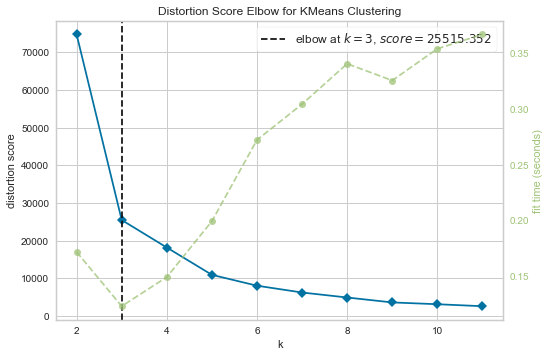

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
# First we find the optimal number of clusters via the 'Elbow Method'
model = KMeans(random_state=1)
K_visualizer = KElbowVisualizer(model, metric= 'distortion', k=(2,12))

K_visualizer.fit(df_10_scaled)
K_visualizer.show()

In [32]:
# Now we fit our model with the optimal number of clusters and examine the count of observations in each cluster.
kmeans = KMeans(n_clusters=K_visualizer.elbow_value_, random_state=1)
kmeans.fit_predict(df_10_scaled)
df_10_scaled['Cluster'] = kmeans.fit_predict(df_10_scaled)

cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns = df_10.columns).rename_axis('Cluster')
cluster_centers['Count'] = pd.Series(kmeans.fit_predict(df_10_scaled)).value_counts()
cluster_centers.style.background_gradient()

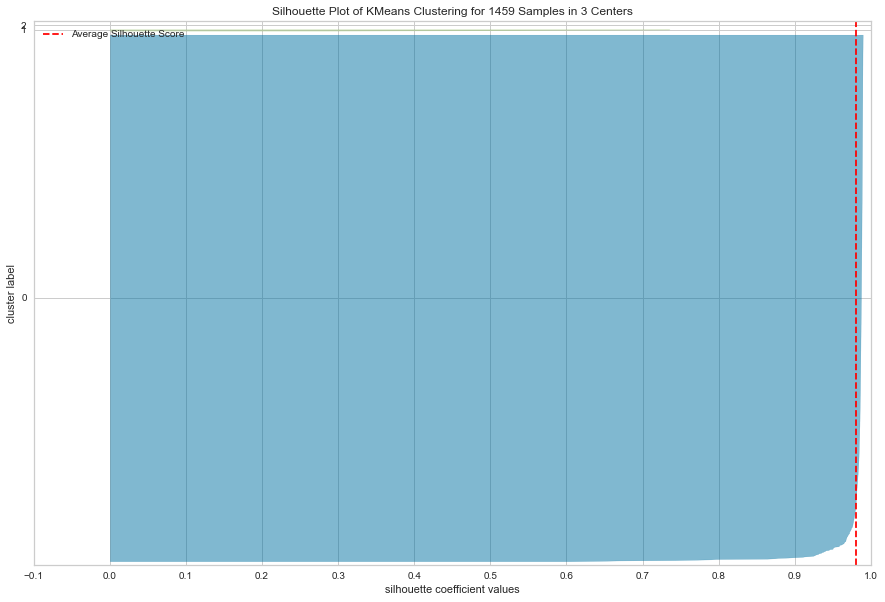

Mean Silhouette Coefficient for All Samples: 0.9809191304521387


In [33]:
# Using the fitted Kmeans model with 3 clusters, let see how our clusters separate themselves via a silhouette
# plot.
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', size=(1080, 720))

visualizer.fit(df_10_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
print("Mean Silhouette Coefficient for All Samples: {}".format(visualizer.silhouette_score_))

>Note on Silhouette scores: Silhouette scores range between -1 and +1, where scores near +1 indicate high separation and scores near -1 indicate that the samples may have been assigned to the wrong cluster. 

We can see a large degree of average separation between the Kmeans clusters, but that is because the most extreme outliers have formed their own clusters, leaving the bulk of the data points to all cluster together as one. (See below)

In [34]:
fig = px.scatter_3d(
    df_10_scaled,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta',
    color= 'Cluster',
    opacity=0.7
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## KMeans Clustering

As the winsorized data set allows us to keep the most variance while not sacrificing our heavy-tailed distribution, we will move forward with testing models against the altered dataset of 'win_scaled'.
<br>
<br>
Let's start with confirming the optimal number of clusters for the KMeans model by plotting the silhouette scores (as they correspond to the number of clusters).

In [35]:
fig = px.scatter_3d(
    win_scaled, 
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta', 
    opacity=0.7
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [36]:
k_list = list(range(2, 12))
scores = []

for k in k_list:
    model = KMeans(n_clusters=k, random_state=1)
    clusters = model.fit_predict(win_scaled)
    silhouette = silhouette_score(win_scaled, clusters)
    scores.append(silhouette)

scores = pd.DataFrame([k_list, scores]).T
scores.columns = ["Clusters", "Score"]

fig = px.line(
    scores, x="Clusters", y="Score", title="Avg. Silhouette Score per K Clusters"
).update(layout=dict(title=dict(x=0.5)))

fig.show()

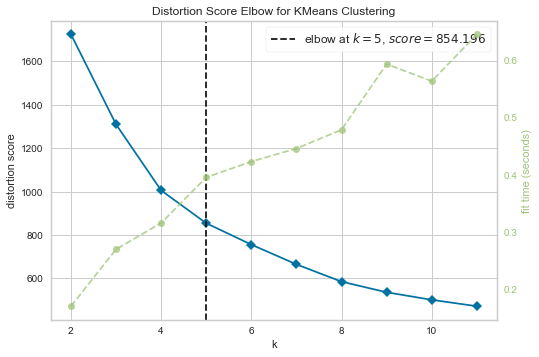

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
model = KMeans(random_state=1)
Kmeans_visualizer = KElbowVisualizer(model, metric= 'distortion', k=(2,12))

Kmeans_visualizer.fit(win_scaled)
Kmeans_visualizer.show()

Based on the silhouette and distortion scores, by the K number of clusters. The optimal number of clusters is between 3-5. Within that constraint, 3 clusters will be most useful as we can very easily imagine a stratum of stocks labeled as: 
>"low-performing
<br>
mid-performing and 
<br>
high-performing"

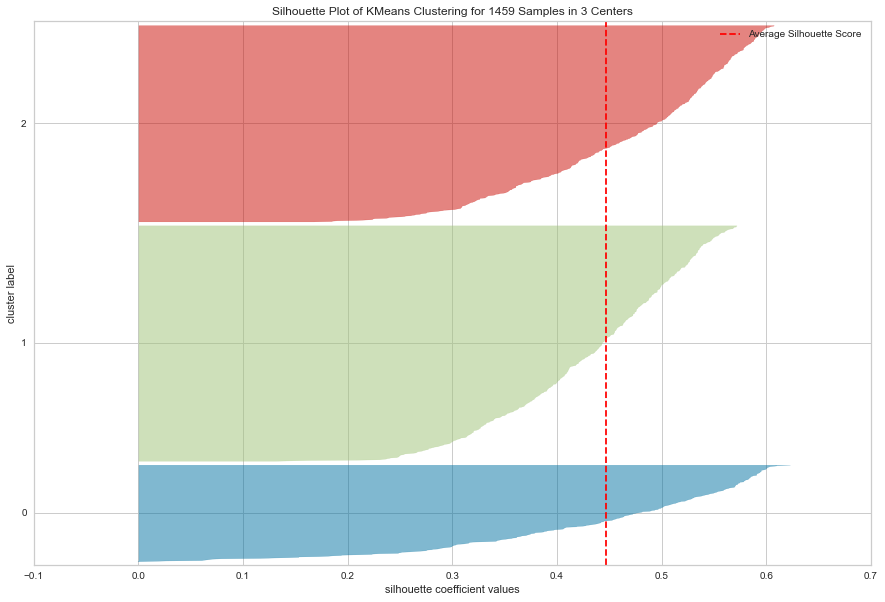

Mean Silhouette Coefficient for All Samples: 0.4469267466736971


In [38]:
kmeans_model = KMeans(n_clusters=3, random_state=1)
kmeans_df = win_scaled.copy()
kmeans_model.fit_predict(kmeans_df)
kmeans_df['Cluster'] = kmeans_model.fit_predict(kmeans_df)

km_cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans_model.cluster_centers_), columns = win_scaled.columns)#.rename_axis('Cluster')
km_cluster_centers['Count'] = pd.Series(kmeans_model.fit_predict(kmeans_df)).value_counts()
display(km_cluster_centers.style.background_gradient())

visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick', size=(1080, 720))
visualizer.fit(kmeans_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
print("Mean Silhouette Coefficient for All Samples: {}".format(visualizer.silhouette_score_))

In [39]:
fig = px.scatter_3d(
    kmeans_df,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta',
    color= 'Cluster',
    opacity=0.7
)
print("The silhoutte score of the KMeans solution: {}"
      .format(metrics.silhouette_score(kmeans_df, kmeans_model.fit_predict(kmeans_df), metric='euclidean')))
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

The silhoutte score of the KMeans solution: 0.4469267466736971


## Hierarchical(Agglomerative) Clustering

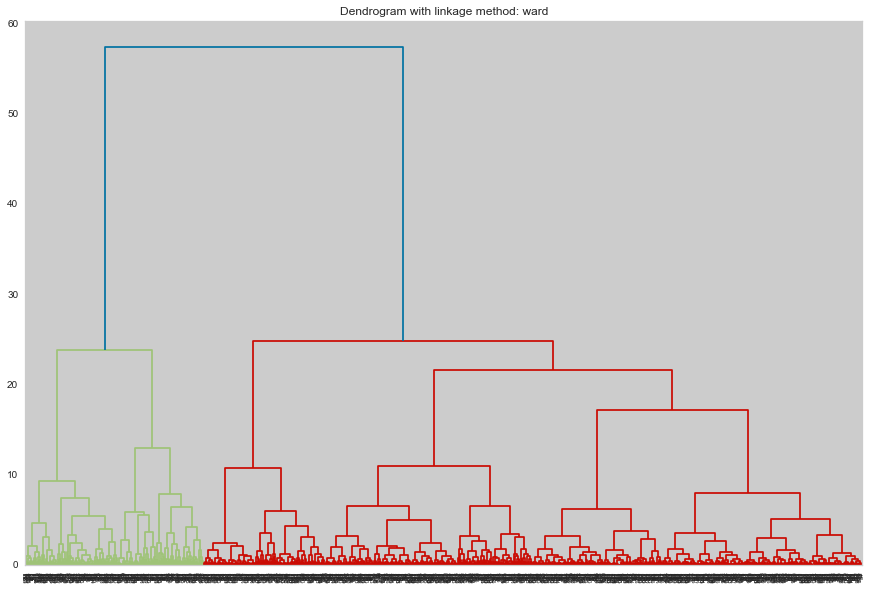

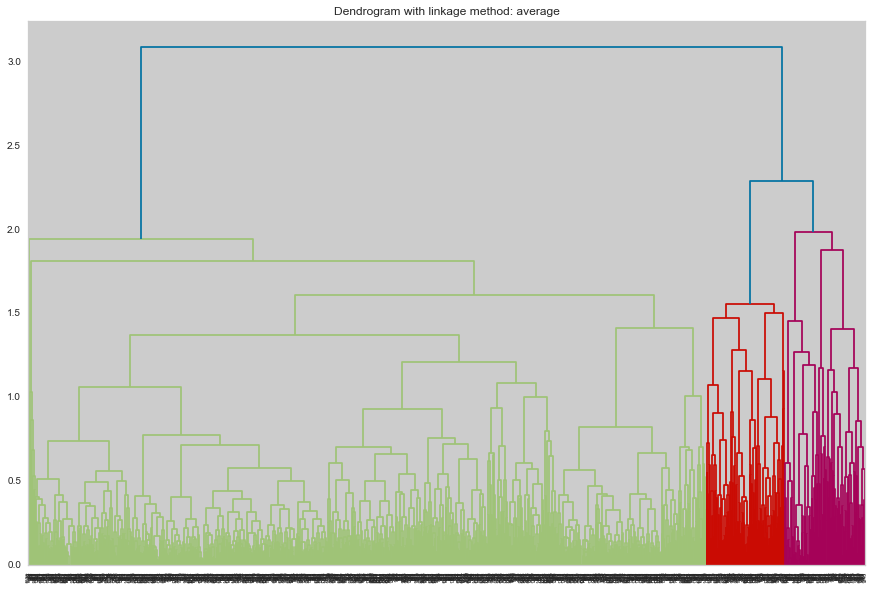

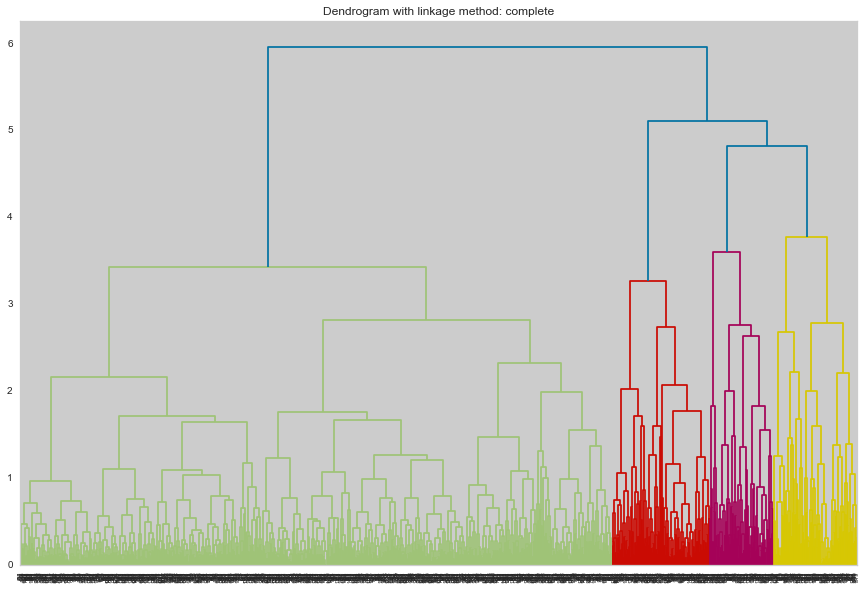

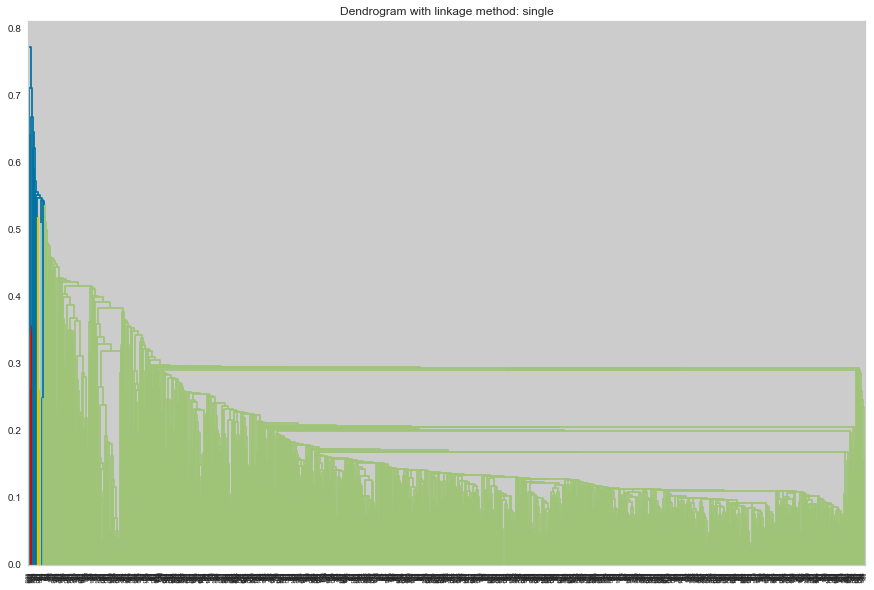

In [40]:
hier_df = win_scaled.copy()
linkage_list = ['ward', 'average', 'complete', 'single']

for i in linkage_list:
    plt.figure(figsize=(15,10))
    plt.title("Dendrogram with linkage method: {}".format(i))
    dendrogram(linkage(hier_df, method=i))
    #plt.axhline(y=40, color='r', linestyle='--')
    plt.show()

ward n_clusters = 2<br>
average n_clusters = 2<br>
complete n_clusters = 4<br>
single n_clusters = N/A<br>
<br>
Ward and complete linkage appear to be the most suitable for testing silhouette scores.

In [41]:
ward_model = AgglomerativeClustering(
    n_clusters=2, 
    affinity='euclidean', 
    linkage='ward',
)  
ward_model.fit_predict(hier_df)
ward_clusters = ward_model.fit_predict(hier_df)

complete_model = AgglomerativeClustering(
        n_clusters=4, 
        affinity='euclidean', 
        linkage='complete'
)  
complete_model.fit_predict(hier_df)
complete_clusters = complete_model.fit_predict(hier_df)

print(
    "The silhoutte score of the Agglomerative Clustering solution with ward linkage: {}".format(metrics.silhouette_score(hier_df, ward_clusters, metric='euclidean'))
)  
print(
    "The silhoutte score of the Agglomerative Clustering solution with complete linkage: {}".format(metrics.silhouette_score(hier_df, complete_clusters, metric='euclidean'))
)  

The silhoutte score of the Agglomerative Clustering solution with ward linkage: 0.5006994248906782
The silhoutte score of the Agglomerative Clustering solution with complete linkage: 0.33640563652437944


Ward linkage scored a higher silhouette score against complete, so we'll construct our final agglomerative model utilizing this linkage method

In [42]:
hier_df['Cluster'] = ward_model.fit_predict(hier_df)  

hier_clusters = hier_df.groupby(
    ['Cluster'], as_index=False).agg(
    {
        "Cluster": "count",
        "returnOnEquity": "mean",
        "returnOnInvestment": "mean",
        "beta": "mean"
    }
)
display(hier_clusters.style.background_gradient())

# Now we can view the clusters
fig = px.scatter_3d(
    hier_df,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta',
    color= 'Cluster',
    opacity=0.7
)
print("The silhoutte score of the Agglomerative Clustering solution: {}"
      .format(metrics.silhouette_score(hier_df, hier_df['Cluster'], metric='euclidean')))
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

The silhoutte score of the Agglomerative Clustering solution: 0.5370479075245935


## Density Based Clustering

Instead of assuming that every point is relevant, we focus on points that are tightly packed and assume everything else is noise. Finding unknown number of clusters of similar density.

Finding the optimal value of EPS, sourced from:
(https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc)
(https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf).
<br>
"We find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced...and select that as epsilon.

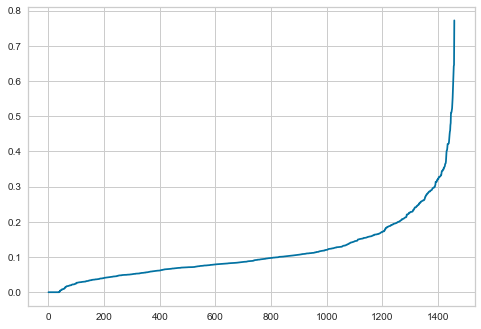

In [43]:
#We are looking for the point of maximum curvature (elbow)
dbscan_df = win_scaled.copy()

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(dbscan_df)
distances, indices = nbrs.kneighbors(dbscan_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

We observed .25 eps to be the point of maximum curvature. Now we can scan through a array of min samples to try and find the elbow of the silhouette score plot

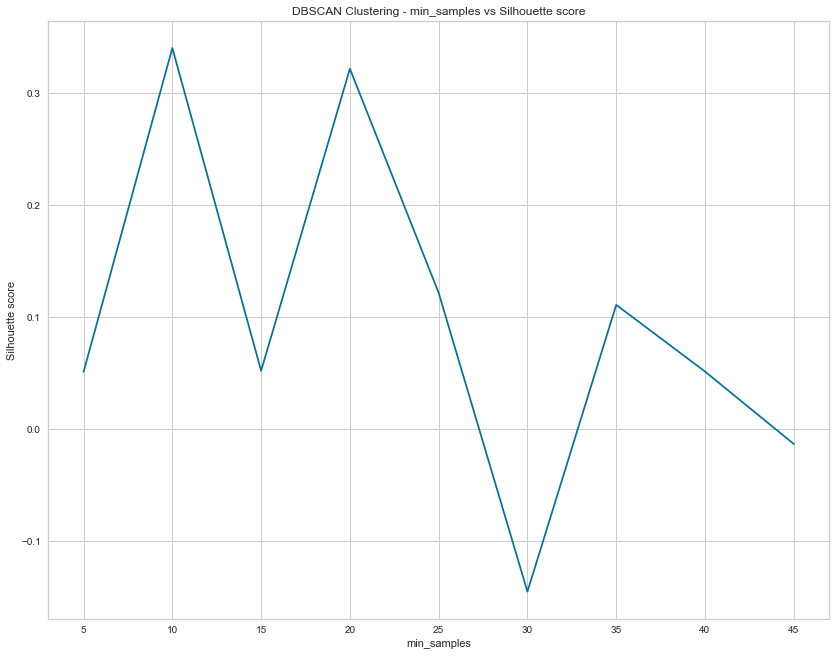

In [44]:
plt.figure(figsize=(14, 11))
silhouette_scores = []

min_sample_list = np.arange(5, 50, 5)

for i in min_sample_list:
    dbscan_model = DBSCAN(eps=0.25, min_samples=i)
    dbscan_cluster = dbscan_model.fit_predict(dbscan_df)
    silhouette_scores.append(silhouette_score(dbscan_df, dbscan_cluster))

plt.plot(min_sample_list, silhouette_scores)
plt.xlabel("min_samples")
plt.ylabel("Silhouette score")
plt.title("DBSCAN Clustering - min_samples vs Silhouette score")
plt.show()

In [45]:
final_dbscan_model = DBSCAN(eps=0.25, min_samples=15, algorithm='auto', n_jobs=-1)
dbscan_df['Cluster'] = final_dbscan_model.fit_predict(dbscan_df)  

final_dbscan_clusters = dbscan_df.groupby(
    ['Cluster'], as_index=False).agg(
    {
        "Cluster": "count",
        "returnOnEquity": "mean",
        "returnOnInvestment": "mean",
        "beta": "mean"
    }
)
display(final_dbscan_clusters.style.background_gradient())

fig = px.scatter_3d(
    dbscan_df,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta',
    color= 'Cluster',
    opacity=0.7
)
print("The silhoutte score of the DBSCAN Clustering solution: {}"
      .format(metrics.silhouette_score(dbscan_df, dbscan_df['Cluster'], metric='euclidean')))
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

The silhoutte score of the DBSCAN Clustering solution: 0.3157221015921187


## Gaussian Mixture Model

In [46]:
gmm_df = win_scaled.copy()

n_list = list(range(2, 12))
scores = []

for n in n_list:
    gmm = GaussianMixture(n_components=n, random_state=1)
    gmm_clusters = gmm.fit_predict(gmm_df)
    silhouette = silhouette_score(gmm_df, gmm_clusters)
    scores.append(silhouette)

scores = pd.DataFrame([n_list, scores]).T
scores.columns = ["Components", "Score"]

fig = px.line(
    scores, x="Components", y="Score", title="Avg. Silhouette Score per n_components"
).update(layout=dict(title=dict(x=0.5)))

fig.show()

In [47]:
c = ['full', 'tied', 'diag', 'spherical']

for i in c:
    print("----- Covariance Type: {} -----".format(i))
    gm_model = GaussianMixture(n_components=3, covariance_type=i, random_state=1)
    gm_model_clusters = gm_model.fit_predict(gmm_df)
    print("The silhoutte score of the GMM solution: {}".format(metrics.silhouette_score(gmm_df, gm_model_clusters, metric='euclidean')))

----- Covariance Type: full -----
The silhoutte score of the GMM solution: 0.20920564935465183
----- Covariance Type: tied -----
The silhoutte score of the GMM solution: 0.25971918730345733
----- Covariance Type: diag -----
The silhoutte score of the GMM solution: 0.2251138799636757
----- Covariance Type: spherical -----
The silhoutte score of the GMM solution: 0.3104536353175688


In [48]:
final_gmm = GaussianMixture(n_components=3, random_state=1)
final_gmm.fit_predict(gmm_df)
gmm_df['Cluster'] = final_gmm.fit_predict(gmm_df)

gmm_centers = pd.DataFrame(scaler.inverse_transform(final_gmm.means_), columns=win_scaled.columns).rename_axis('Cluster')
gmm_centers['Count'] = pd.Series(final_gmm.fit_predict(gmm_df)).value_counts()
gmm_centers.style.background_gradient()

In [49]:
fig = px.scatter_3d(
    gmm_df,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta',
    color= 'Cluster',
    opacity=0.7
)
print("The silhoutte score of the Gaussian Mixture solution: {}"
      .format(metrics.silhouette_score(gmm_df, gmm_df['Cluster'], metric='euclidean')))
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

The silhoutte score of the Gaussian Mixture solution: 0.3591680848258023


The Gaussian Mixture Model, also gives us 3 clusters, but it completely ignores any distinction between the clusters with regard to beta.

# Final Model Selection

Kmeans seems to be the best suited model for this clustering application. The three clusters have a strong semblance of balance and the silhouette score is the 2nd highest among the group. Above all else, beta values carry more weight in the clustering distinction when the ROI and ROE are lower. This is a useful distinction.

In [50]:
fig = px.scatter_3d(
    kmeans_df,
    x='returnOnEquity', 
    y='returnOnInvestment', 
    z='beta',
    color= 'Cluster',
    opacity=0.7
)
print("The silhoutte score of the KMeans solution: {}"
      .format(metrics.silhouette_score(kmeans_df, kmeans_model.fit_predict(kmeans_df), metric='euclidean')))
print("The silhoutte score of the Agglomerative Clustering solution: {}"
      .format(metrics.silhouette_score(hier_df, hier_df['Cluster'], metric='euclidean')))
print("The silhoutte score of the DBSCAN Clustering solution: {}"
      .format(metrics.silhouette_score(dbscan_df, dbscan_df['Cluster'], metric='euclidean')))
print("The silhoutte score of the Gaussian Mixture solution: {}"
      .format(metrics.silhouette_score(gmm_df, gmm_df['Cluster'], metric='euclidean')))
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

The silhoutte score of the KMeans solution: 0.4469267466736971
The silhoutte score of the Agglomerative Clustering solution: 0.5370479075245935
The silhoutte score of the DBSCAN Clustering solution: 0.3157221015921187
The silhoutte score of the Gaussian Mixture solution: 0.3591680848258023


# Conclusion

This model could be a tool in the vast arsenal for assessing past performance in order to try and formulate asset allocation for future investments. Let's take a look at how that might occur.

In [51]:
display(km_cluster_centers.style.background_gradient())

We can derive several key insights:
<br>
1. Low-Performing: 
>Cluster 1 groups companies with the lowest returns, while also grouping those with the most volatility 
<br>
2. Mid-Performing: 
>Cluster 0 has experienced the lowest volatility, while its companies performing slightly better than Cluster 1 (with regard to returns). This seems to be our "safest bet" cluster.
<br>
3. High-Performing: 
>Cluster 2 has experienced better returns in the past than the other two clusters, while experiencing relatively mild volatility.

In [65]:
final_kmeans_df = pd.merge(kmeans_df, labels, on='symbol', how='inner')
#final_kmeans_df

Let's examine what other insights we can gather from the re-labeling of the companies, their sectors, 
and their industries.

In [64]:
replaced_df = final_kmeans_df.copy()
replaced_df['Cluster'] = replaced_df['Cluster'].replace({2: 'High-Performing', 1: 'Low-Performing', 0: 'Mid-Performing'})
replaced_df

symbol  returnOnEquity  returnOnInvestment      beta          Cluster  \
0      AAPL        3.304147            2.357171  0.248844  High-Performing   
1      ACTG        0.100757            1.019866 -0.442637   Mid-Performing   
2      ACCO       -0.144621           -0.384346  1.493121   Low-Performing   
3        AB        0.435273            1.436673  0.628201   Mid-Performing   
4        AC       -0.389778           -0.502504  0.339233   Low-Performing   
...     ...             ...                 ...       ...              ...   
1460    XEL       -0.084004           -0.416940 -1.261567   Mid-Performing   
1461   ZUMZ        0.240447            0.395833  0.822052   Low-Performing   
1462    ZTO        0.039247            0.749023 -1.209391   Mid-Performing   
1463    ZTS        2.992475            1.112802 -0.621679  High-Performing   
1464   ZYXI        1.230388            2.454170 -0.028408  High-Performing   

                                Name             Sector  \
0                         Apple Inc.         Technology   
1        Acacia Research Corporation      Miscellaneous   
2            Acco Brands Corporation  Consumer Durables   
3     AllianceBernstein Holding L.P.            Finance   
4     Associated Capital Group, Inc.            Finance   
...                              ...                ...   
1460                Xcel Energy Inc.   Public Utilities   
1461                     Zumiez Inc.  Consumer Services   
1462       ZTO Express (Cayman) Inc.     Transportation   
1463                     Zoetis Inc.        Health Care   
1464                     Zynex, Inc.        Health Care   

                                               Industry  
0                                Computer Manufacturing  
1                                Multi-Sector Companies  
2                                            Publishing  
3                                   Investment Managers  
4                    Investment Bankers/Brokers/Service  
...                                                 ...  
1460                                   Power Generation  
1461                     Clothing/Shoe/Accessory Stores  
1462                  Trucking Freight/Courier Services  
1463                              Major Pharmaceuticals  
1464  Biotechnology: Electromedical & Electrotherape...  

[1465 rows x 8 columns]

In [55]:
final_kmeans_df.to_csv(r'C:\Users\ASUS\Thinkful_Projects\Capstone_3\Clustering_Capstone\clustered_df.csv', index=False, header=True)

# Implications

AS a potential investor, we would examine each sector, looking for opportunities where the count of companies in Cluster 2 exceeds the count of Cluster 1, by the largest margin possible. This would indicate that a sector has created high returns with relatively low volatility.

1. Sadly, that seldom happens. We only see that occur in **Miscellaneous and Health Care sectors**
>a. The **Public Utilities** sector appears to be have been an incredible source of market stability. One may not have invested in the strongest performing companies, by participating in this sector, but at least you weren't investing in weak businesses.<br>
>b. Theoretically, a potential investor looking to create a stable investment portfolio could look at the historical performance<br>
2. **Consumer Durables** and Capital goods experienced the greatest volatility compared to ROE and ROI.
3. Surprise! **Technology** created the largest returns, as long as you could stomach the volatility.

<AxesSubplot:>

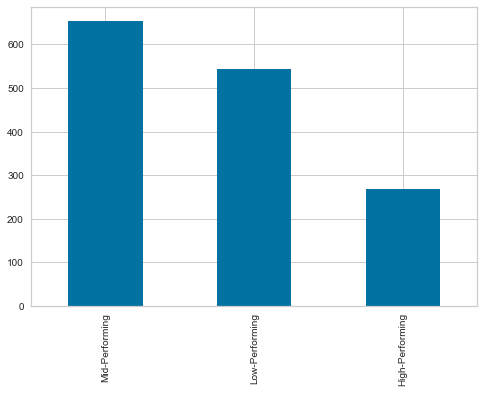

In [68]:
replaced_df['Cluster'].value_counts().plot(kind='bar')

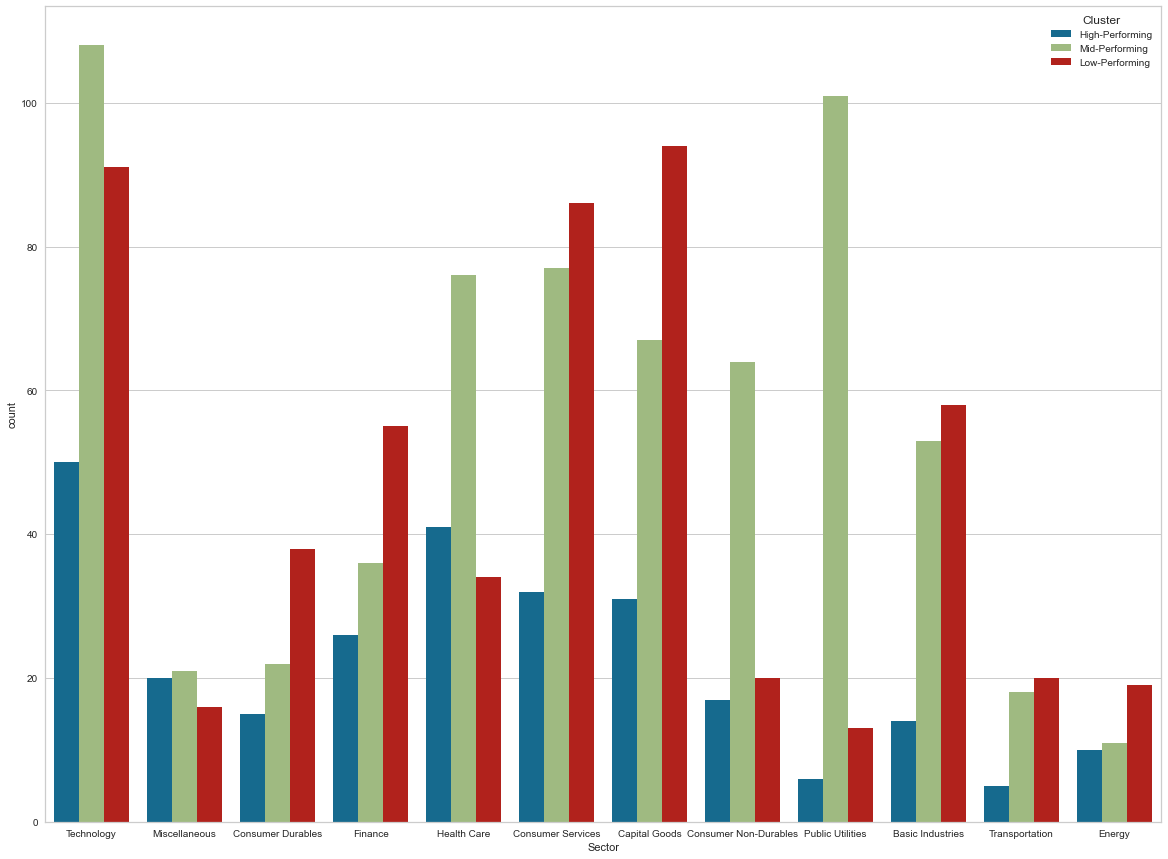

In [95]:
plt.figure(figsize=(20,15))
ax=sns.countplot(
    x='Sector',
    hue='Cluster',
    data=replaced_df, 
)

<Figure size 1440x1080 with 0 Axes>

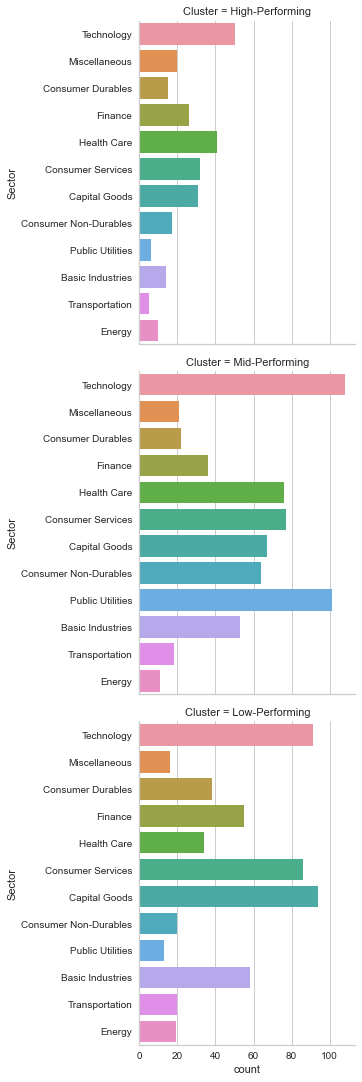

In [91]:
plt.figure(figsize=(20,15))
ax=sns.catplot(
    y='Sector', 
    row='Cluster',
    hue_order='Sector',
    data=replaced_df, 
    kind='count'
)

In [96]:
# We can also examine what industries were most present in each cluster. 
# 0: Low Performing
# 1: High Performing
# 2: Mid-Performing
fig = px.sunburst(replaced_df, path=['Cluster', 'Industry'], width=1000, height=1000)
fig.show()

An incorporation of more metrics, could be used to gain a more holistic view of the clusters. If we were to extend this analysis and model configuration further, we should try and maintain as much variance as possible by not removing so many outliers, but still have the model be useful.